In [1]:
API_KEY="LS8cRqQq74DEh1ftwGrmuYx0DzHqybiFak4SnCY_O3ZO"


In [2]:
%pip install "qc-grader[qiskit,jupyter] @ git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git"

  Cloning https://github.com/qiskit-community/Quantum-Challenge-Grader.git to /tmp/pip-install-8n4qj9ro/qc-grader_f74f6d01498f4d8992f56151190302d8
  Running command git clone --filter=blob:none --quiet https://github.com/qiskit-community/Quantum-Challenge-Grader.git /tmp/pip-install-8n4qj9ro/qc-grader_f74f6d01498f4d8992f56151190302d8
  Resolved https://github.com/qiskit-community/Quantum-Challenge-Grader.git to commit 6e0ab831d1945987a5e64021e4ef6e000116009c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of ibm-cloud-sdk-core to determine which version is compatible with other

In [2]:
%pip install qiskit-ibm-runtime

In [3]:
import qiskit
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout
from qiskit_aer import AerSimulator

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
token=API_KEY, # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="niloy", # Optional
overwrite=True
)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
# Run every time you need the service
service = QiskitRuntimeService()
backend=service.least_busy(operational=True, min_num_qubits=20)
print(backend)

<IBMBackend('ibm_fez')>


In [ ]:
# unique_edges = set()
# for a, b in coupling_map:
#     edge = tuple(sorted((a, b)))
#     unique_edges.add(edge)


# n = backend.configuration().num_qubits
# print(n)
# graph = rx.PyGraph()
# graph.add_nodes_from(np.arange(0, n, 1))
# edge_list = [(a, b, 1.0) for a, b in unique_edges]
# graph.add_edges_from(edge_list)


# draw_graph(graph, node_size=200, with_labels=True)

In [6]:
config = backend.configuration()
coupling_map = config.coupling_map

In [7]:
class ClinicalTrial:
    rho: float  # Relative importance between first and second moments
    w: np.ndarray  # Normalized patient covariates

    def assert_valid(self, group1: np.ndarray, group2: np.ndarray) -> None:
        """
        Checks if the patient constraints are met.

        Arguments (where n is the number of patients):
            - group1: np.ndarray(size = n) => Binary array of patients belonging to group 1
            - group2: np.ndarray(size = n) => Binary array of patients belonging to group 2
        Throws an AssertionError if the constraints are not met.
        """
        group_size = int(self.w.shape[0] / 2)
        # constraint 1: number of people in each group
        assert (
            np.sum(group1) == group_size
        ), f"Each group should have {group_size} patients"
        # contraint 2: every patient is in one group
        assert (
            group1 + group2 == 1
        ).all(), "Every patient needs to be assigned to one group"

    def discrepancy(self, group1: np.ndarray, group2: np.ndarray) -> float:
        """
        Calculates discrepancy between patient groups.

        Arguments (where n is the number of patients):
            - group1: np.ndarray(size = n) => Binary array of patients belonging to group 1
            - group2: np.ndarray(size = n) => Binary array of patients belonging to group 2
        Returns:
            - float => Value of discrepancy measure for group1 and group2
        """
        # Check that all the constraints are being met
        self.assert_valid(group1, group2)

        # Order of the groups is arbitrary
        if group1[0] == 0:
            group1, group2 = group2, group1

        n, r = self.w.shape

        # Calculate mean values for each covariate
        Mu = []
        for i in range(r):
            Mu.append(self.w[:, i].dot(group1 - group2) / n)

        # Calculate second moments (variance and covariance)
        Var_ii = []  # variance
        Var_ij = []  # covariance

        for i in range(r):
            for j in range(i, r):
                if i == j:
                    Var_ii.append((self.w[:, i] ** 2).dot(group1 - group2) / n)
                else:
                    Var_ij.append(
                        (self.w[:, i] * self.w[:, j]).dot(group1 - group2) / n
                    )

        # Calculate final discrepancy
        discrepancy = (
            np.sum(np.abs(Mu))
            + self.rho * np.sum(np.abs(Var_ii))
            + 2 * self.rho * np.sum(np.abs(Var_ij))
        )
        return discrepancy


import numpy as np
import torch
import time
from typing import Tuple, Dict, List

def build_Q1(w: np.ndarray) -> np.ndarray:
    n = w.shape[0]
    w_sum = np.sum(w, axis=0)
    Q1 = np.zeros((n, n))

    for i in range(n):
        # Diagonal part
        for s in range(w.shape[1]):
            Q1[i, i] += 4 * (w[i, s]**2 - w[i, s] * w_sum[s])

        # Off-diagonal part
        for j in range(i + 1, n):
            for s in range(w.shape[1]):
                Q1[i, j] += 8 * w[i, s] * w[j, s]

    return Q1


def build_Q2(w: np.ndarray, rho: float = 0.5) -> np.ndarray:
    n = w.shape[0]
    Q2 = np.zeros((n, n))

    u = w**2
    u_sum = np.sum(u, axis=0)

    for i in range(n):
        Q2[i, i] = rho * np.sum(4 * (u[i]**2 - u[i] * u_sum))

    for i in range(n):
        for j in range(i + 1, n):
            Q2[i, j] = rho * np.sum(8 * u[i] * u[j])

    return Q2


def build_Q3(w: np.ndarray, rho: float = 0.5) -> np.ndarray:
    n_samples, n_features = w.shape
    Q3 = np.zeros((n_samples, n_samples))

    # Build all v_i^(ss') for s' > s
    pair_list = []
    for s in range(n_features):
        for sp in range(s + 1, n_features):
            pair_list.append((s, sp))

    n_pairs = len(pair_list)
    V = np.zeros((n_samples, n_pairs))
    for idx, (s, sp) in enumerate(pair_list):
        V[:, idx] = w[:, s] * w[:, sp]

    v_total = np.sum(V, axis=0)

    # Diagonal entries
    for i in range(n_samples):
        v_i = V[i]
        Q3[i, i] = 2.0 * rho * np.sum(4.0 * (v_i**2 - v_i * v_total))

    # Off-diagonal entries
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            v_i = V[i]
            v_j = V[j]
            Q3[i, j] = 2.0 * rho * np.sum(8.0 * v_i * v_j)

    return Q3


def add_group_size_penalty(Q: np.ndarray, lam_size: float = 3.0) -> np.ndarray:
    Q_new = Q.copy()
    n = Q.shape[0]

    for i in range(n):
        Q_new[i, i] += lam_size * (1.0 - n)

    for i in range(n):
        for j in range(i + 1, n):
            Q_new[i, j] += 2.0 * lam_size

    return Q_new


def QUBO_formulation(W: np.ndarray,
                     rho: float = 0.5,
                     lam_size: float = 3.0,
                     normalize: bool = True) -> np.ndarray:

    Q1 = build_Q1(W)
    Q2 = build_Q2(W, rho)
    Q3 = build_Q3(W, rho)

    Q = Q1 + Q2 + Q3

    if normalize:
        max_abs = np.max(np.abs(Q))
        if max_abs > 0.0:
            Q = Q / max_abs

    Q_final = add_group_size_penalty(Q, lam_size=lam_size)

    return Q_final

In [8]:
from io import StringIO
import numpy as np

w_data = """
-0.7650636535189481,0.283894442848472,-0.655816465582355
-0.5856817886844943,1.2319371664692689,0.910198903115477
-0.854754585936175,-0.3306700946565902,-0.054686355633081954
0.22153660307055117,1.2078202901666337,-0.6382331351268004
0.400918467905005,-0.04542566114612644,-0.4096498392045905
-0.1372271265983581,0.47572063137057313,3.984424441638505
-0.1372271265983581,-0.27827825993017496,0.1980740196655155
0.8493731299911412,0.21597910153645256,-0.42613421150667297
-0.7650636535189481,1.1249358532184994,-0.08325926762335818
-0.1372271265983581,0.14113362335585988,1.382750909108507
1.925664318997869,0.538646274137218,-0.372285261986537
0.3112275354877781,0.29415104541396137,-0.20579310173550433
0.7596821975739143,0.5652579997125404,-0.24150924172334964
0.13184567065332425,-0.42297951774598436,-0.09809520269523238
0.6699912651566874,-2.1402674337783933,0.40028231990439345
-0.5856817886844943,-0.49948822877502536,-0.6052643905226355
-0.1372271265983581,0.5788410679749358,-0.6909831264934643
0.22153660307055117,-0.9424625774142155,3.0009667900962667
-0.1372271265983581,-0.18458280946707206,1.9861888311800715
1.1184459272428235,0.07848518606396536,-0.5876810600670809
-0.5856817886844943,-1.5392859645357366,-0.23546497187925275
-0.854754585936175,-1.0267330417360687,-0.41954046258584
0.3112275354877781,1.6823960629265113,-0.12941551006918903
-0.4959908562672674,1.1784365098438845,-0.0563347928632902
-0.4062999238500389,-0.034060236681667924,-0.4140456718184792
-0.4959908562672674,-1.010100713251496,-0.2310691392653641
-0.9444455183534036,-1.2224401069045752,-0.3305248521545948
0.8493731299911412,0.5339337810665824,2.334888253276789
-0.5856817886844943,-1.79653264509717,-0.11128270053689834
-0.4062999238500389,1.039279361522928,-0.439871188425075
0.04215473823609734,0.7701128455475578,-0.3568998478379267
-1.0341364507706305,1.2319371664692689,-0.2871160050924444
-1.0341364507706305,-1.3943075012451869,-0.6431784468174251
-0.9444455183534036,0.4901353160571981,-0.5448216920816665
0.13184567065332425,1.948790524154465,0.25302192733912365
2.19473711624955,1.742826856420469,-0.3865717179816751
-0.047536194181131176,-0.05928593488327222,-0.6459258422011055
0.13184567065332425,-1.2745547361562415,-0.628891990822287
-0.6753727211017212,-0.0942138247008759,-0.39426442505598025
-0.1372271265983581,0.7665091743759014,-0.790438839382695
5.692683480521414,1.1975636876011444,-0.6415300095872168
-0.1372271265983581,1.334780397598892,2.2075190032893652
-0.1372271265983581,-1.042810959271162,3.1909766548316036
-1.3929001804395398,-0.2976826431621845,-0.5349310687004171
0.49060940032223355,-0.5690668029355032,-0.6343867815896478
-0.854754585936175,0.5527837533491035,-0.4970170124056275
0.3112275354877781,-0.17515782332581153,-0.298105586627166
0.400918467905005,0.5200735073294374,-0.25854309310216816
0.22153660307055117,0.12422408939654765,-0.4662461841084069
-0.854754585936175,0.5333793701171032,-0.09864468177196847
2.2844280486667783,-0.7370533206297188,-0.2129363297330734
-1.1238273831878574,0.1691313763049011,-0.5266888825493758
2.19473711624955,1.1448946473999888,-0.6602122981962437
-0.047536194181131176,0.5769006296517378,-0.40855088105111836
-0.5856817886844943,2.2354209850386475,-0.5948242880646499
-0.1372271265983581,1.00906396477596,-0.34371234999626077
2.015355251415096,-0.4933897083306817,-0.5635039806906933
0.7596821975739143,-0.41161409328152654,1.9673966467556976
-0.4959908562672674,-2.2081827750904024,0.03377977572142715
-0.5856817886844943,-1.0563940275335575,-0.25854309310216816
1.1184459272428235,0.822504680273963,-0.5497670037722913
0.3112275354877781,-0.7772481144674374,0.16070944244746196
-0.6753727211017212,0.161369623012099,1.1431780316515756
-0.5856817886844943,0.5949189855100293,-0.642628967740689
-0.5856817886844943,1.2100379339645713,-0.6805430240354787
0.5803003327394605,0.17717033507244279,-0.40250661120702147
-1.2135183156050844,-1.703946016533026,-0.2920613167830691
-0.7650636535189481,-0.9915279464437146,0.83546974867937
-1.1238273831878574,-0.9455118376363927,0.07938653909052192
-0.1372271265983581,-0.6713556231156471,-0.5558112736163882
-0.31660899143281196,1.0620102104518552,-0.5596576271535407
0.04215473823609734,-1.776019439966191,0.16455579598461453
-0.5856817886844943,0.805317940839901,-0.026113443642805722
0.22153660307055117,-0.11472702983185462,0.03597769202837148
0.8493731299911412,-1.3275009818321366,-0.43217848135076986
-0.854754585936175,-2.067362393920999,-0.22667330665147542
-0.5856817886844943,-0.6142512953185962,-0.3579988059913989
-0.047536194181131176,-0.964361809918913,-0.33601964292195563
-0.854754585936175,-0.08340281118590664,-0.4310795231972977
-0.5856817886844943,-1.629932154776673,-0.5047097194799326
-0.854754585936175,1.709007788501833,-0.47009253764555947
0.22153660307055117,1.058960950229678,-0.6250456372851344
-1.0341364507706305,-0.8049686619417282,-0.46789462133861515
-0.4959908562672674,1.955166250073549,-0.6321888652827035
-0.4062999238500389,0.2248496767282231,-0.2931602749365413
0.22153660307055117,-0.15769387841701005,4.715231613697493
-0.9444455183534036,0.4934617817541149,-0.6332878234361756
-0.22691805901558504,-0.5552065291983574,-0.27942329801813925
-0.854754585936175,-1.2448937503587518,-0.6272435535920787
1.477209656911733,-0.44848242142232825,0.2717042159481504
-0.1372271265983581,-0.7722584159220621,1.8509070824876483
1.1184459272428235,0.30579367535315943,-0.39096755059556376
-0.6753727211017212,0.34238479801922156,0.16730319136829494
-0.7650636535189481,-0.6835526640043345,0.18268860551690522
0.400918467905005,-0.6635938698228451,0.052462064330453924
1.925664318997869,1.5379720105854517,-0.6102097022132602
-0.4062999238500389,-0.17377179595209344,-0.16458217098029823
1.387518724494506,0.6583990392261534,-0.5497670037722913
-0.31660899143281196,-0.8227098123252801,-0.10249103530912104
0.7596821975739143,0.6425983271658103,-0.5525143991559717
"""

w = np.loadtxt(StringIO(w_data), delimiter=",")
print(w[0])   # (100, 3)

n_patients , n_covariates = w.shape
rho = 0.5
trial = ClinicalTrial()
trial.w = w
trial.rho = rho



[-0.76506365  0.28389444 -0.65581647]


In [9]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

def build_pauli_hamiltonian_from_Q(Q: np.ndarray) -> SparsePauliOp:
    """
    Correctly builds a Pauli Hamiltonian from a QUBO matrix Q using x_i -> (I - Z_i) / 2.
    """
    n = Q.shape[0]
    sparse_list = []

    # 1. Handle Diagonal Terms: Q_ii * x_i
    for i in range(n):
        if Q[i, i] != 0:
            # Q_ii * (I - Z_i)/2  -> -Q_ii/2 * Z_i  (ignoring Identity for cost H)
            sparse_list.append(("Z", [i], -Q[i, i] / 2.0))

    # 2. Handle Off-Diagonal Terms: Q_ij * x_i * x_j
    # Ensure we only take each pair once (assuming Q might be symmetric)
    for i in range(n):
        for j in range(i + 1, n):
            val = Q[i, j] + Q[j, i] # Handle both upper/lower triangle if present
            if val != 0:
                # val * (I - Z_i - Z_j + Z_i Z_j)/4
                coeff = val / 4.0
                sparse_list.append(("ZZ", [i, j], coeff))
                sparse_list.append(("Z", [i], -coeff))
                sparse_list.append(("Z", [j], -coeff))

    # 3. Combine all terms and simplify
    H_c = SparsePauliOp.from_sparse_list(sparse_list, num_qubits=n).simplify()

    return H_c

In [10]:
Q = QUBO_formulation(w, rho=0.5, lam_size=3.0, normalize=True)

H = build_pauli_hamiltonian_from_Q(Q)
print(H)
print("Number of Pauli terms:", len(H))
cost_hamiltonian = H

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In [11]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def get_warm_start_closest_pairs(W: np.ndarray):
    """
    Implements the "closest pairs" classical warm-start algorithm.

    It follows the problem constraints:
    1. [cite_start]Total N patients, N/2 in each group[cite: 30].
    2. [cite_start]Patient 1 (index 0) is fixed to group 1[cite: 32, 35].

    The logic is:
    1. Fix patient 0 to group 1.
    2. Find the patient (j) closest to patient 0 and put them in group 2.
    3. From the remaining patients, find the closest pair (i, k).
    4. Put one in group 1, the other in group 2.
    5. Repeat until all patients are assigned.
    """
    n_patients = W.shape[0]
    group_size = n_patients // 2

    # Calculate a matrix of all pairwise distances
    dist_matrix = squareform(pdist(W, 'euclidean'))

    # Use sets for easy tracking
    group1 = set()
    group2 = set()
    remaining = set(range(n_patients))

    # [cite_start]1. Constraint: Patient 0 MUST be in group 1 [cite: 32, 35]
    group1.add(0)
    remaining.remove(0)

    # 2. Find patient closest to patient 0 and put in group 2
    #    (We only search the remaining patients)
    dists_from_p0 = dist_matrix[0, list(remaining)]
    j = list(remaining)[np.argmin(dists_from_p0)]

    group2.add(j)
    remaining.remove(j)

    # 3. Loop until groups are full
    while len(remaining) > 0:
        # Find the closest pair (i, k) from the remaining pool
        min_dist = float('inf')
        best_pair = (None, None)

        remaining_list = list(remaining)
        for idx1 in range(len(remaining_list)):
            for idx2 in range(idx1 + 1, len(remaining_list)):
                i = remaining_list[idx1]
                k = remaining_list[idx2]

                if dist_matrix[i, k] < min_dist:
                    min_dist = dist_matrix[i, k]
                    best_pair = (i, k)

        i, k = best_pair

        # 4. Assign one to each group
        #    (We fill group1 first since it's 1 patient behind)
        if len(group1) < group_size:
            group1.add(i)
            group2.add(k)
        else:
            # This case should only happen if n_patients is odd
            # but for our problem, we assume n_patients is even
            group1.add(k)
            group2.add(i)

        remaining.remove(i)
        remaining.remove(k)

    # Convert sets to the binary array format for scoring
    group1_binary = np.zeros(n_patients, dtype=int)
    group2_binary = np.zeros(n_patients, dtype=int)

    for i in group1:
        group1_binary[i] = 1
    for i in group2:
        group2_binary[i] = 1

    return group1_binary, group2_binary


print("Computing classical 'closest pairs' warm-start...")
g1_classical, g2_classical = get_warm_start_closest_pairs(w)

print(f"Group 1 assignment: {g1_classical}")
print(f"Group 2 assignment: {g2_classical}")


discrepancy_score = trial.discrepancy(g1_classical, g2_classical)
print(f"Classical Discrepancy: {discrepancy_score}")

Computing classical 'closest pairs' warm-start...
Group 1 assignment: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Group 2 assignment: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Classical Discrepancy: 0.568369537979882


In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap

service = QiskitRuntimeService()
backend = service.least_busy(min_num_qubits=100, operational=True)

props = backend.properties()
coupling = CouplingMap(backend.configuration().coupling_map)

# Compute a simple "quality" score for each qubit
scores = []
for q in range(len(props.qubits)):
    T1 = props.qubits[q][0].value          # energy-relaxation time
    T2 = props.qubits[q][1].value          # dephasing time
    read_err = props.readout_error(q)      # readout error
    score = (T1 + T2) / 2 - 1e4 * read_err # heuristic
    scores.append((score, q))

# Sort descending and print the top 100
best_qubits = [q for _, q in sorted(scores, reverse=True)]
print("Top 100 qubits by =coherence score:", best_qubits[:100])


Top 100 qubits by =coherence score: [132, 143, 2, 137, 115, 142, 13, 37, 44, 19, 92, 80, 21, 16, 110, 4, 90, 14, 74, 54, 36, 23, 6, 5, 141, 84, 75, 8, 88, 126, 50, 119, 124, 58, 17, 147, 154, 64, 127, 148, 152, 121, 106, 25, 123, 38, 146, 59, 144, 112, 20, 71, 130, 9, 28, 15, 94, 120, 70, 24, 30, 85, 57, 109, 118, 111, 18, 116, 82, 48, 114, 68, 86, 102, 108, 136, 100, 79, 42, 56, 104, 125, 52, 153, 134, 27, 46, 103, 150, 22, 69, 95, 151, 139, 97, 122, 140, 29, 98, 117]


In [13]:
import networkx as nx

# --- Step 1: Re-calculate best_qubits to include scores ---
# (Assuming you still have the 'scores' list from earlier)
# scores = [(score_val, qubit_idx), ...]
best_qubits_with_scores = sorted(scores, reverse=True)

# --- Step 2: Build Graph ---
coupling_map_list = backend.configuration().coupling_map
hw_graph = nx.Graph()
hw_graph.add_edges_from(coupling_map_list)

# --- Step 3: DFS Function ---
def find_strict_linear_path(graph, start_node, target_length):
    path = [start_node]
    visited = set([start_node])
    stack = [(start_node, iter(graph.neighbors(start_node)))]

    while stack and len(path) < target_length:
        parent, children = stack[-1]
        try:
            child = next(children)
            if child not in visited:
                visited.add(child)
                path.append(child)
                stack.append((child, iter(graph.neighbors(child))))
        except StopIteration:
            stack.pop()
            if len(path) < target_length and path:
                 visited.remove(path.pop())
    return path

# --- Step 4: Main Search Loop ---
target_length = 100
linear_100 = []

print(f"Searching for a linear path of {target_length} qubits...")

# We use the new list that strictly contains tuples: (score, index)
for score, start_qubit in best_qubits_with_scores:
    path = find_strict_linear_path(hw_graph, start_qubit, target_length)
    if len(path) == target_length:
        linear_100 = path
        print(f"SUCCESS: Found linear path starting at qubit {start_qubit} with score {score:.2e}")
        break

if len(linear_100) < target_length:
    print("\nCRITICAL ERROR: Unable to find ANY linear path of 100 qubits on this device.")
else:
    print(f"\nFinal selected linear path ({len(linear_100)} qubits):")
    print(linear_100)
    connected_100 = linear_100

Searching for a linear path of 100 qubits...
SUCCESS: Found linear path starting at qubit 132 with score 1.88e+02

Final selected linear path (100 qubits):
[132, 131, 130, 129, 118, 109, 108, 107, 97, 87, 86, 85, 77, 65, 64, 63, 56, 43, 42, 41, 36, 21, 22, 23, 16, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 37, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 59, 75, 74, 73, 72, 71, 70, 69, 78, 89, 90, 91, 92, 93, 94, 95, 99, 115, 114, 113, 119, 133, 134, 135, 139, 155, 154, 153, 152, 151, 150, 149, 148, 147, 137, 127, 126, 125]


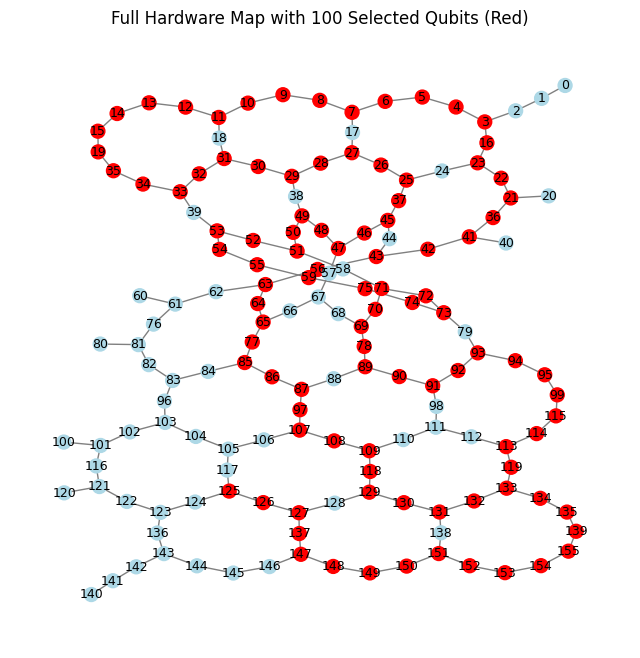

In [14]:
import matplotlib.pyplot as plt

# 1. Define color map: Red for selected nodes, Light Blue for the rest
# We iterate through all nodes in the full graph to ensure alignment
node_colors = ['red' if node in connected_100 else 'lightblue' for node in hw_graph.nodes()]

# 2. Set up the plot
plt.figure(figsize=(8, 8))     # Large figure size for readability
plt.title(f"Full Hardware Map with {len(connected_100)} Selected Qubits (Red)")

# 3. Calculate layout (Kamada-Kawai usually works well for qubit lattices)
# This might take a few seconds for large graphs
pos = nx.kamada_kawai_layout(hw_graph)

# 4. Draw the graph
nx.draw(
    hw_graph,
    pos,
    node_color=node_colors,
    with_labels=True,
    node_size=100,
    font_size=9,
    font_color='black',
    edge_color='gray'
)

plt.show()

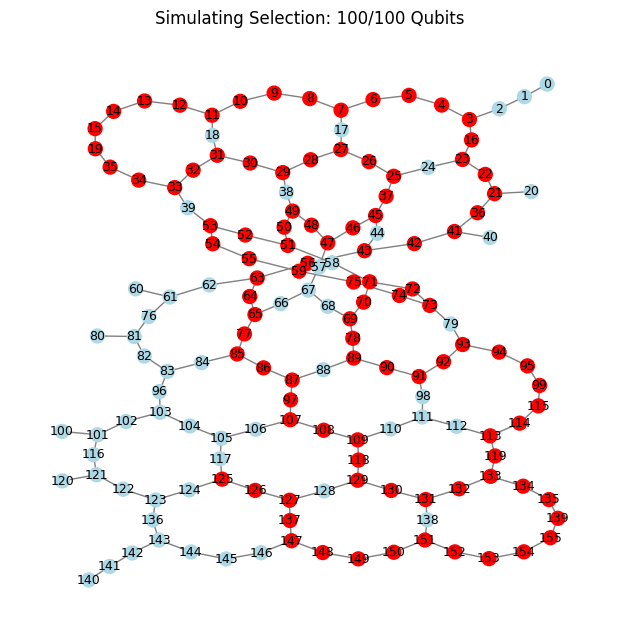

Simulation complete.


In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import time
from IPython.display import clear_output

# 1. Ensure layout is fixed so nodes don't jump around between frames
if 'pos' not in locals():
    print("Calculating graph layout...")
    pos = nx.kamada_kawai_layout(hw_graph)

print("Starting simulation...")

# 2. Loop through the selection one qubit at a time
for i in range(1, len(linear_100) + 1):
    # A. Identify currently selected subset
    current_subset = set(linear_100[:i])

    # B. Update color map for this frame
    node_colors = ['red' if node in current_subset else 'lightblue' for node in hw_graph.nodes()]

    # C. Create the plot for this frame
    plt.figure(figsize=(6, 6))
    nx.draw(
        hw_graph,
        pos,
        node_color=node_colors,
        with_labels=True,
        node_size=100,
        font_size=9,
        edge_color='gray',
        font_color='black'
    )
    plt.title(f"Simulating Selection: {i}/{len(linear_100)} Qubits")

    # D. Clear previous frame and display the new one
    clear_output(wait=True)
    plt.show()

    # E. Wait 1 second before next update
    time.sleep(0.1)

print("Simulation complete.")

In [16]:
n_qubits = w.shape[0]
warm_start_circuit = QuantumCircuit(n_qubits)

# Apply an X-gate for every '1' in the classical solution
# This prepares the state |100101...> from the default |000000...>
for i, bit in enumerate(g1_classical):
    if bit == 1:
        warm_start_circuit.x(i)

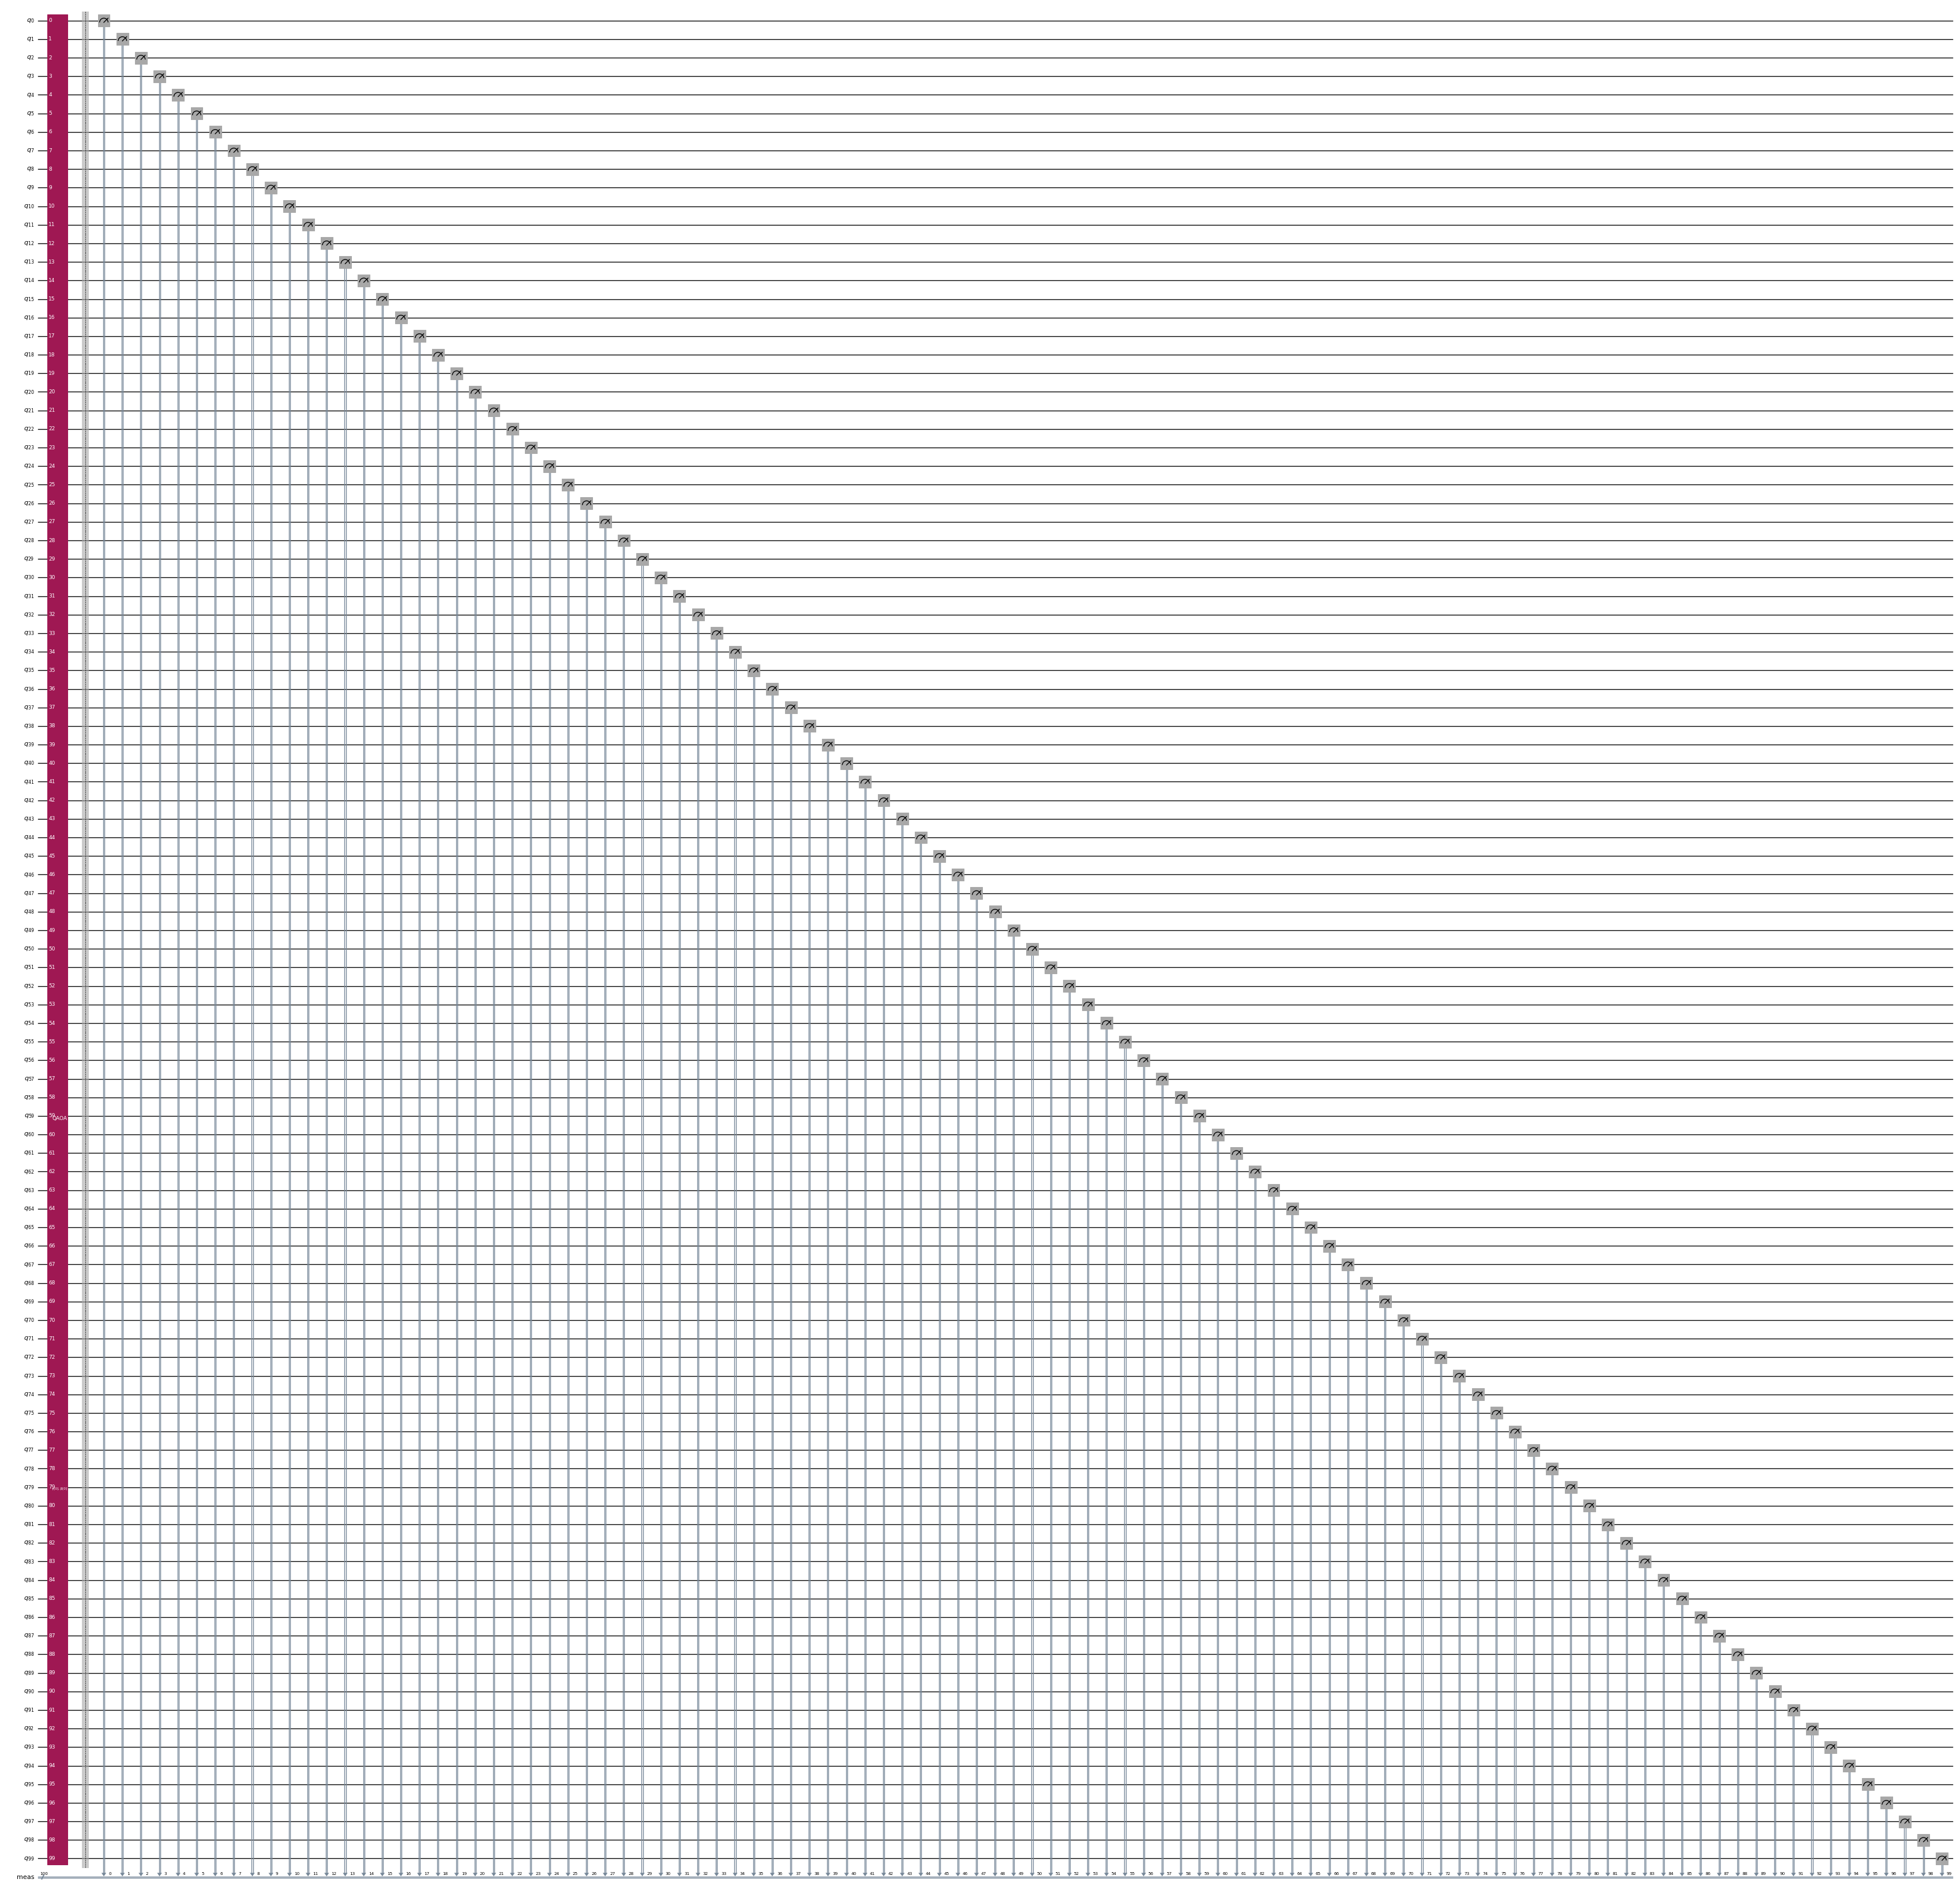

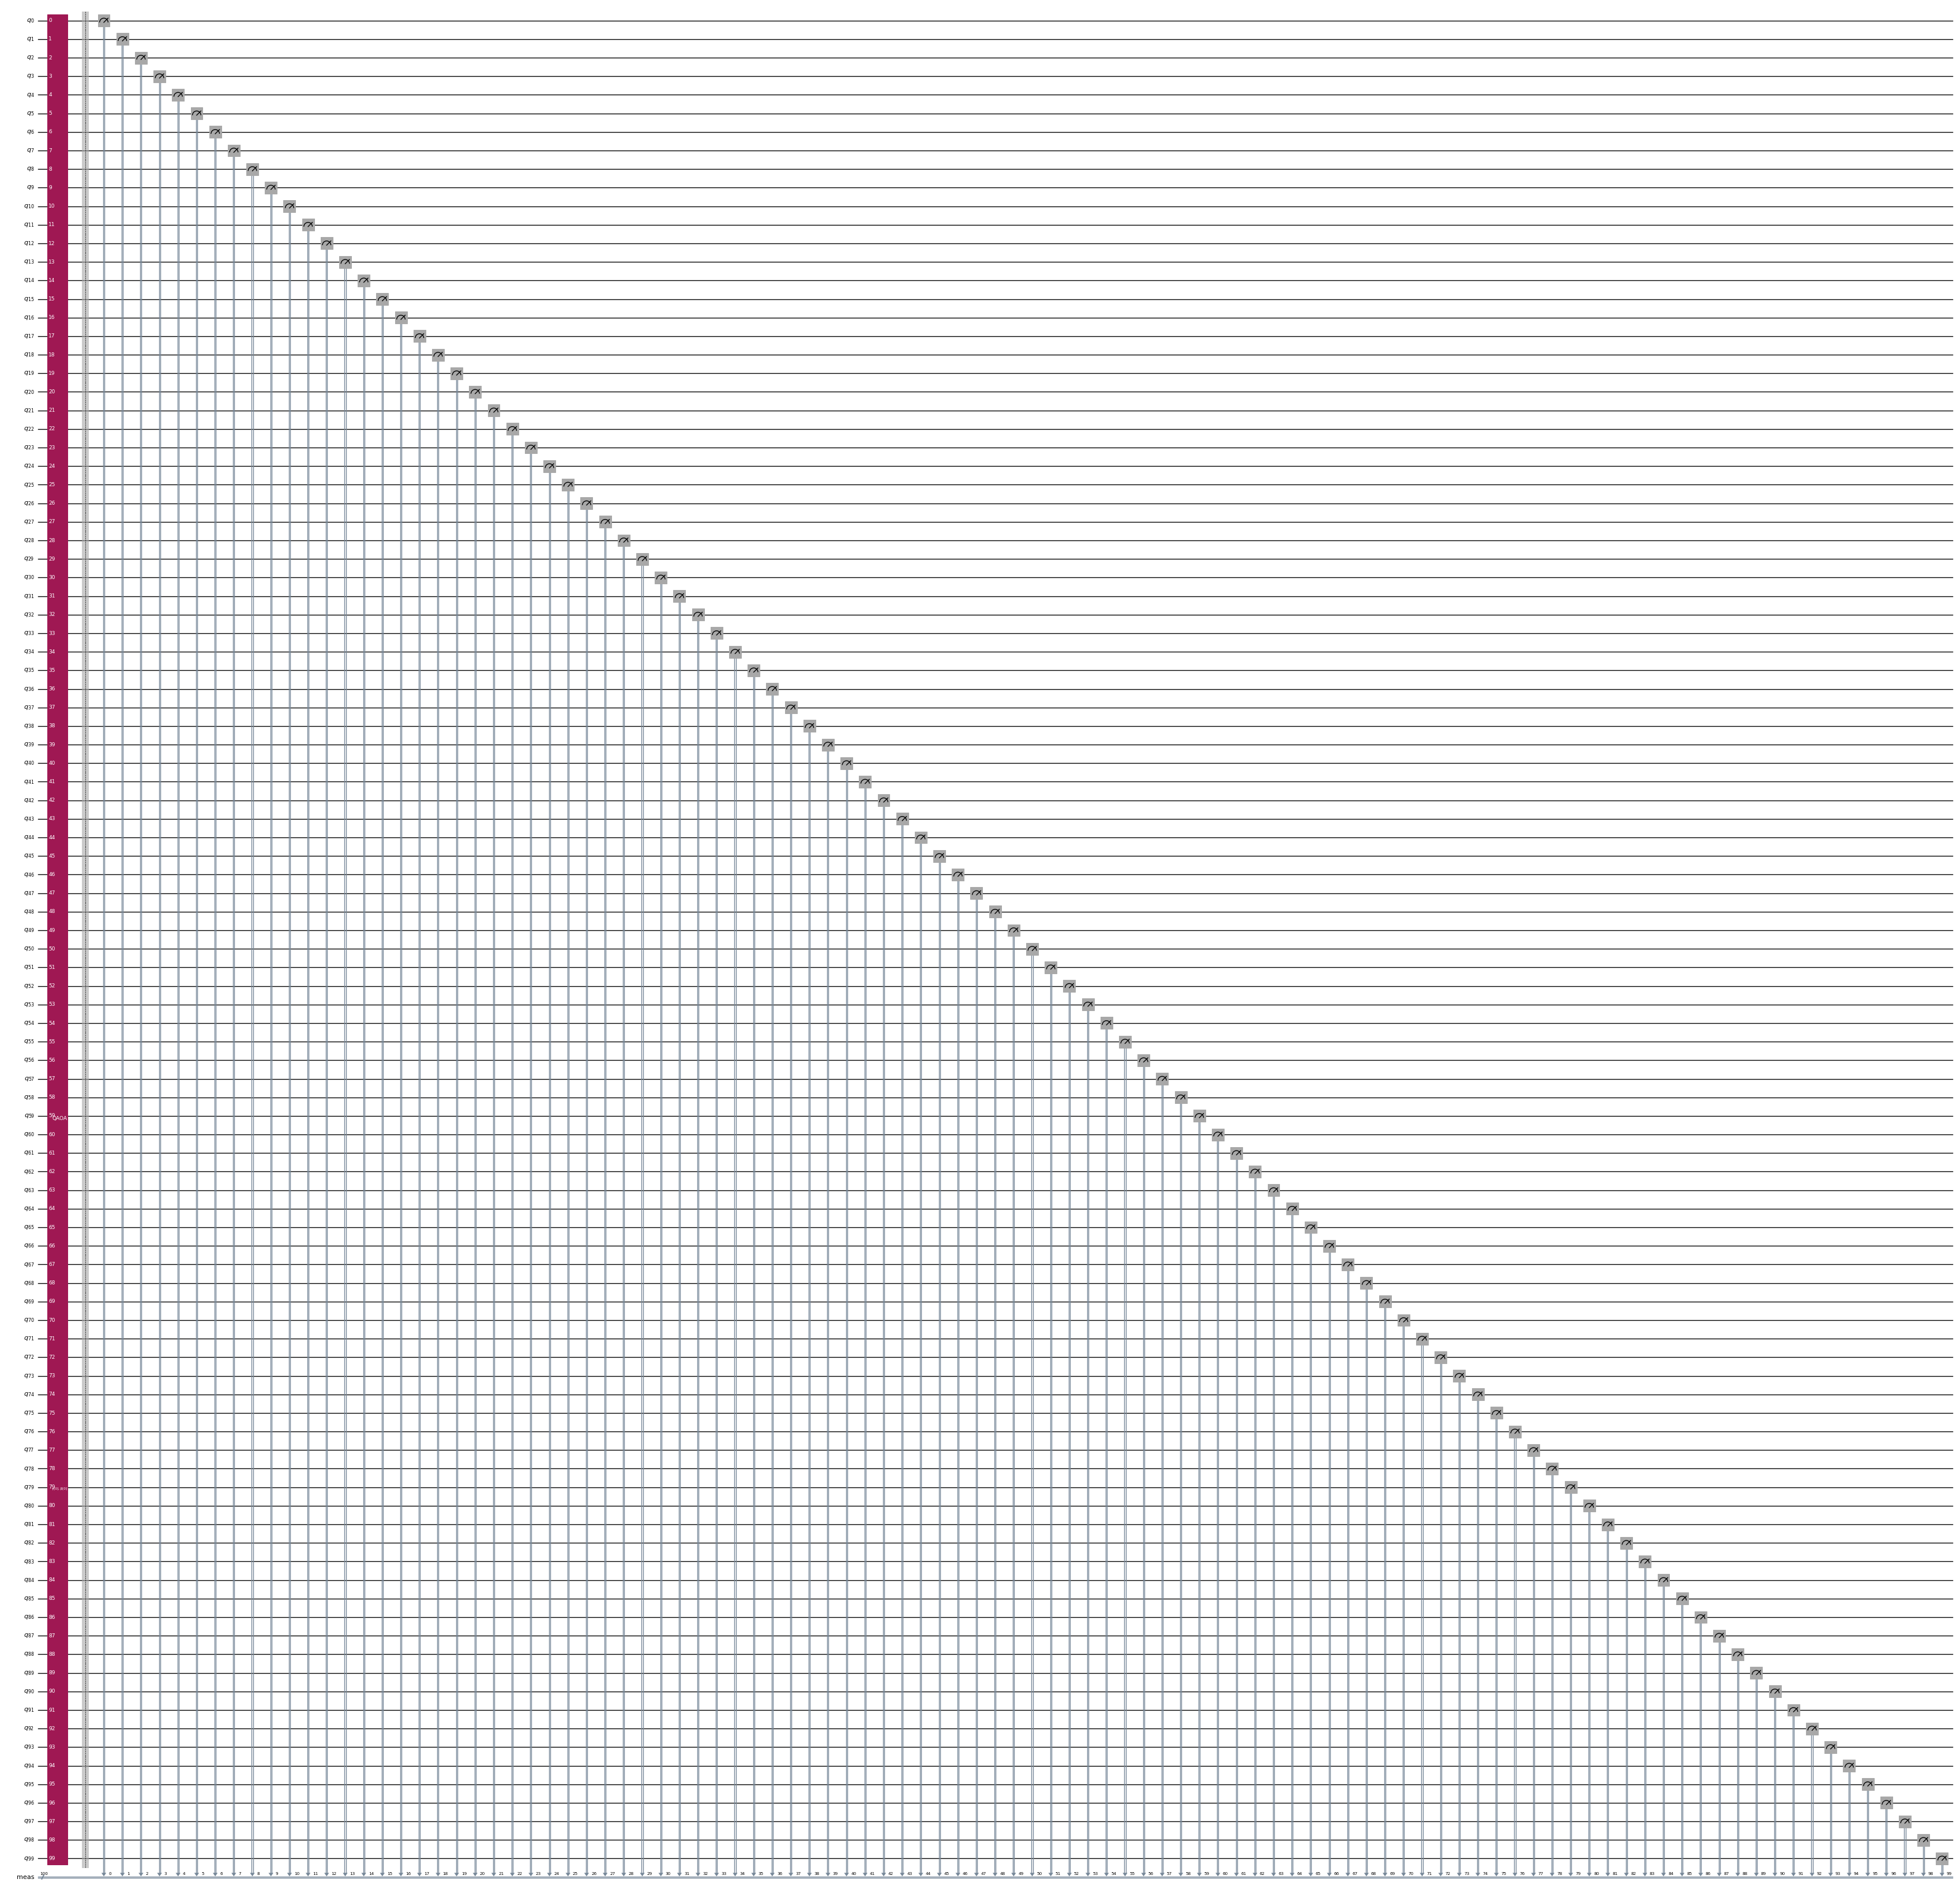

In [17]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import transpile


def create_xy_linear_mixer(n_qubits: int) -> SparsePauliOp:
    pauli_list = []
    # Loop only up to n_qubits - 1 to avoid wrapping around
    for i in range(n_qubits - 1):
        j = i + 1

        # XX term
        xx_paulis = ['I'] * n_qubits
        xx_paulis[i] = 'X'
        xx_paulis[j] = 'X'
        pauli_list.append(("".join(xx_paulis)[::-1], 0.5))

        # YY term
        yy_paulis = ['I'] * n_qubits
        yy_paulis[i] = 'Y'
        yy_paulis[j] = 'Y'
        pauli_list.append(("".join(yy_paulis)[::-1], 0.5))

    return SparsePauliOp.from_list(pauli_list)

# 2. Create the perfectly matched mixer
xy_mixer_linear = create_xy_linear_mixer(n_qubits)


# 3. Build the full QAOA Ansatz with Warm Start

qaoa_circuit = QAOAAnsatz(
    cost_operator=cost_hamiltonian,
    mixer_operator=xy_mixer_linear,
    initial_state=warm_start_circuit,
    reps=1
)
qaoa_circuit.measure_all()
qaoa_circuit.draw("mpl", fold=-1, idle_wires=False, scale=0.5)

In [46]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
generic_backend=backend
seed=43
# Create a Pass Manager that RESPECTS your specific 100-qubit linear chain
pm = generate_preset_pass_manager(
    optimization_level=3,
    backend=generic_backend,
    initial_layout=connected_100,  # <--- CRITICAL: Locks precisely to your chosen qubits
    seed_transpiler=seed
)

# Now run it. It will optimize gates BUT keep them on your chosen linear path.
qaoa_circuit_transpiled = pm.run(qaoa_circuit)

# Visualize: It should look like a neat, long line without extra SWAPs if done right.
#qaoa_circuit_transpiled.draw("mpl", fold=-1, idle_wires=False, scale=0.5)

In [ ]:
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# 1. Robust Callback Function
# We use **kwargs to handle potential variations in arguments across Qiskit versions
def transpiler_callback(pass_, dag, time_taken=None, property_set=None, count=0, **kwargs):
    """
    Robust callback that handles 'time' or 'time_taken' and ignores extras.
    """
    # Some versions pass 'time', others might pass 'time_taken' positionally.
    # We check kwargs for 'time' if time_taken is None.
    if time_taken is None:
         time_taken = kwargs.get('time', 0.0)

    print(f"Pass {count}: {pass_.name()} - {time_taken:.4f}s")

# 2. Setup Pass Manager (same as before)
pm = generate_preset_pass_manager(
    optimization_level=3,
    backend=generic_backend,
    initial_layout=connected_100,
    seed_transpiler=43
)

print("Starting transpilation with progress tracking...")
start_time = time.time()

# 3. Run with the robust callback
qaoa_circuit_transpiled = pm.run(
    qaoa_circuit,
    callback=transpiler_callback
)

total_time = time.time() - start_time
print(f"\nTranspilation finished in {total_time:.2f} seconds total.")

# 4. Draw
display(qaoa_circuit_transpiled.draw("mpl", fold=-1, idle_wires=False, scale=0.5))

Starting transpilation with progress tracking...
Pass 0: ContainsInstruction - 0.0000s
Pass 1: UnitarySynthesis - 0.0001s
Pass 2: HighLevelSynthesis - 5.8224s
Pass 3: BasisTranslator - 0.0010s
Pass 4: ElidePermutations - 0.0000s
Pass 5: RemoveDiagonalGatesBeforeMeasure - 0.0001s
Pass 6: RemoveIdentityEquivalent - 0.0001s
Pass 7: InverseCancellation - 0.0009s
Pass 8: ContractIdleWiresInControlFlow - 0.0000s
Pass 9: CommutativeCancellation - 0.0030s
Pass 10: ConsolidateBlocks - 0.0011s
Pass 11: Split2QUnitaries - 0.0000s
Pass 12: SetLayout - 0.0001s
Pass 13: FullAncillaAllocation - 0.0001s
Pass 14: EnlargeWithAncilla - 0.0002s
Pass 15: ApplyLayout - 0.0261s
Pass 16: CheckMap - 0.0009s
Pass 17: BarrierBeforeFinalMeasurements - 0.0018s
Pass 18: SabreSwap - 0.3328s
Pass 19: FilterOpNodes - 0.0065s
Pass 20: UnitarySynthesis - 0.0000s
Pass 21: HighLevelSynthesis - 0.0018s
Pass 22: BasisTranslator - 0.0760s
Pass 23: Depth - 0.0234s
Pass 24: Size - 0.0000s
Pass 25: MinimumPoint - 0.0000s
Pass 2

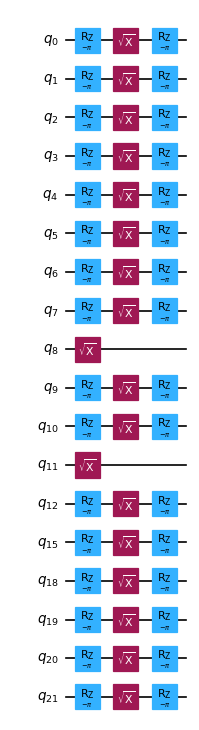

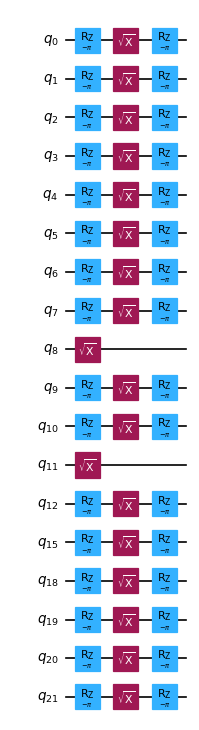

In [47]:
# Create a smaller dummy circuit with just the first 50 operations for quick visualization
from qiskit import QuantumCircuit

# Extract first 50 instructions
mini_circ = QuantumCircuit(qaoa_circuit_transpiled.num_qubits)
for instruction in qaoa_circuit_transpiled.data[:50]:
    mini_circ.append(instruction)

display(mini_circ.draw("mpl", idle_wires=False, fold=-1, scale=0.6))

In [50]:
layers=1
init_params = np.zeros(2 * layers)

In [51]:
import rustworkx as rx
import numpy as np
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw as draw_graph
from qiskit_ibm_runtime import QiskitRuntimeService
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.quantum_info import SparsePauliOp, Statevector, DensityMatrix, Operator
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import Layout

from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_ibm_runtime.debug_tools import Neat
from qiskit_aer import AerSimulator

In [53]:
import json
import time
import numpy as np
from qiskit_ibm_runtime import SamplerV2 as Sampler

def run_qaoa_and_save_bitstrings(params, circuit, backend, shots=4096, filename="qaoa_bitstring_history.json"):
    """
    Runs QAOA circuit using Sampler to get bitstrings and saves results to a file.
    """
    print(f"Starting Sampler job with {shots} shots...")

    # 1. Initialize Sampler (specifically for getting bitstrings)
    sampler = Sampler(mode=backend)
    sampler.options.default_shots = shots

    # 2. Prepare Pub (Sampler pub format is just (circuit, parameter_values))
    pub = (circuit, params)

    # 3. Run and wait for result
    job = sampler.run([pub])
    result = job.result()[0]

    # 4. Extract counts (the bitstrings)
    # 'meas' is the default name for the classical register created by measure_all()
    counts = result.data.meas.get_counts()

    # 5. Persist results to a JSON file
    # We convert numpy types to python types for JSON serialization
    record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "job_id": job.job_id(),
        "params": [float(p) for p in params], # Ensure they are standard floats
        "shots": shots,
        "counts": counts
    }

    # Append record to file (one JSON object per line for easy reading later)
    try:
        with open(filename, "a") as f:
            json.dump(record, f)
            f.write("\n")
        print(f"Results successfully saved to {filename}")
    except Exception as e:
        print(f"Warning: Could not save to file: {e}")

    return counts, record

# --- USAGE ---
# Run the new function
bitstring_counts, full_record = run_qaoa_and_save_bitstrings(
    init_params,
    qaoa_circuit_transpiled,
    backend,
    shots=2 # Higher shots recommended for good statistics
)

# --- Display Results ---
print("\nMost frequent bitstrings found:")
sorted_counts = sorted(bitstring_counts.items(), key=lambda x: x[1], reverse=True)
for bs, count in sorted_counts[:5]:
    print(f"Bitstring: {bs} | Count: {count}")

Starting Sampler job with 2 shots...
Results successfully saved to qaoa_bitstring_history.json

Most frequent bitstrings found:
Bitstring: 1000111001010001100100110101101111100111110111111011111101011011110100011010111000100100110011010110 | Count: 1
Bitstring: 0001111011001000110110010111010110100101101110110101110000100101101101011010100111111111001001100100 | Count: 1


In [56]:
for i, (bitstring, count) in enumerate(sorted_counts):

    # 1. Convert bitstring to the correct format
    # CRITICAL: Qiskit bitstrings are little-endian (rightmost is qubit 0).
    # We must reverse it [::-1] so index 0 maps to patient 0.
    g1_solution = np.array([int(bit) for bit in bitstring[::-1]])
    g2_solution = 1 - g1_solution

    # 2. Try to calculate the discrepancy
    try:
        # We use the 'trial' object defined in the beginning
        score = trial.discrepancy(g1_solution, g2_solution)
        print(f"Candidate {i+1}: {bitstring} (Count: {count})")
        print(f"  -> VALID: Discrepancy Score = {score:.4f}")

        # Check against the classical benchmark
        if 'discrepancy_score' in locals():
            if score < discrepancy_score:
                print("  -> SUCCESS: Better than classical benchmark!")
            else:
                print("  -> NOTE: Not better than classical benchmark.")

    except AssertionError as e:
        # This catches solutions that violate constraints (e.g., wrong group size)
        print(f"Candidate {i+1}: {bitstring} (Count: {count})")
        print(f"  -> INVALID: {e}")

Candidate 1: 1000111001010001100100110101101111100111110111111011111101011011110100011010111000100100110011010110 (Count: 1)
  -> INVALID: Each group should have 50 patients
Candidate 2: 0001111011001000110110010111010110100101101110110101110000100101101101011010100111111111001001100100 (Count: 1)
  -> INVALID: Each group should have 50 patients


Running this part needs credits

In [ ]:
objective_func_vals = []  # keep track of values



def cost_func_estimator(params, ansatz, hamiltonian, estimator: Estimator) -> float:
    if hamiltonian.num_qubits != ansatz.num_qubits:
        hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])
    result = job.result()[0]
    cost = result.data.evs
    objective_func_vals.append(cost)
    return cost


def train_qaoa(params, circuit, hamiltonian, backend):
    # job mode: pass backend as mode
    estimator = Estimator(mode=backend)
    # set shots AFTER init (this is accepted)
    estimator.options.default_shots = 4096

    result = minimize(
        cost_func_estimator,
        params,
        args=(circuit, hamiltonian, estimator),
        method="COBYLA",
        options={"maxiter": 200},
    )
    return result, objective_func_vals

result_qaoa, objective_func_vals = train_qaoa(
    init_params,
    qaoa_circuit_transpiled,
    cost_hamiltonian,
    backend,
)


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
opt_params = result_qaoa.x
SHOTS = 1000


def sample_qaoa(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    # sampler = Sampler(mode=backend, options=options)
    sampler = Sampler(mode=backend)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f" {backend.name}"))

    return counts_list


counts_list = sample_qaoa(opt_params, qaoa_circuit_transpiled, generic_backend)

In [ ]:
for i, (bitstring, count) in enumerate(sorted_counts):

    # 1. Convert bitstring to the correct format
    # CRITICAL: Qiskit bitstrings are little-endian (rightmost is qubit 0).
    # We must reverse it [::-1] so index 0 maps to patient 0.
    g1_solution = np.array([int(bit) for bit in bitstring[::-1]])
    g2_solution = 1 - g1_solution

    # 2. Try to calculate the discrepancy
    try:
        # We use the 'trial' object defined in the beginning
        score = trial.discrepancy(g1_solution, g2_solution)
        print(f"Candidate {i+1}: {bitstring} (Count: {count})")
        print(f"  -> VALID: Discrepancy Score = {score:.4f}")

        # Check against the classical benchmark
        if 'discrepancy_score' in locals():
            if score < discrepancy_score:
                print("  -> SUCCESS: Better than classical benchmark!")
            else:
                print("  -> NOTE: Not better than classical benchmark.")

    except AssertionError as e:
        # This catches solutions that violate constraints (e.g., wrong group size)
        print(f"Candidate {i+1}: {bitstring} (Count: {count})")
        print(f"  -> INVALID: {e}")